# Imports

In [54]:
import logging
import boto3
from botocore.exceptions import ClientError
import pandas as pd
import io

from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input
from sagemaker import get_execution_role
from sagemaker import Session
from sagemaker.estimator import Estimator

In [55]:
bucket_name = 'aida-project'
region = 'eu-central-1'

In [56]:
session = boto3.Session(
    region_name=region
)

In [57]:
# Now we can create low-level clients or resource clients from our custom session
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')

# Training

## Data

In [58]:
train_data = 's3://aida-project/niy/train.csv'
test_data = 's3://aida-project/niy/test.csv'

train_data_full = 's3://aida-project/niy/merged/train.csv'
test_data_full = 's3://aida-project/niy/merged/test.csv'

# create s3 paths for the objects
s3_input_train = s3_input(train_data_full, content_type='text/csv')
s3_input_test = s3_input(test_data_full, content_type='text/csv')

data_channels = {'train': s3_input_train, 'validation': s3_input_test}

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [59]:
# get execution role
role = get_execution_role()
# create session
sess = Session()

## XGBoost

In [60]:
# Use a previously-built, AWS XGBoost model for training
container = get_image_uri(region_name=region,
                          repo_name='xgboost',
                          repo_version='1.0-1')

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


In [83]:
# create an XGBoost Estimator
xgb_model = Estimator(container,
                      role, 
                      train_instance_count=1,
                      train_instance_type='ml.m4.xlarge',
                      output_path='s3://aida-project/niy/output',
                      sagemaker_session=sess,
                      base_job_name='niy')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


In [84]:
# Select the your specific hyperparameters
xgb_model.set_hyperparameters(max_depth=5,
                            eta=0.2,
                            gamma=4,
                            min_child_weight=6,
                            subsample=0.8,
                            silent=0,
                            objective='reg:squarederror',
                            num_round=100)

In [63]:
xgb_model.fit({"train": s3_input_train, "validation": s3_input_test}, wait=True)

2020-11-19 10:26:21 Starting - Starting the training job...
2020-11-19 10:26:22 Starting - Launching requested ML instances......
2020-11-19 10:27:29 Starting - Preparing the instances for training......
2020-11-19 10:28:48 Downloading - Downloading input data
2020-11-19 10:28:48 Training - Downloading the training image...
2020-11-19 10:29:16 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[10:29:26] 561179x288 matrix with 161619552 entries loaded from /o

# Hyperparameter Tuning

In [85]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter
from sagemaker.tuner import ContinuousParameter
from sagemaker.tuner import HyperparameterTuner

The hyperparameters that have the greatest effect on optimizing the XGBoost evaluation metrics are: alpha, min_child_weight, subsample, eta, and num_round. 

In [ ]:
train_data_full = 's3://aida-project/niy/merged/train.csv'
test_data_full = 's3://aida-project/niy/merged/test.csv'

In [ ]:
s3_input_train = s3_input(train_data_full, content_type='text/csv')
s3_input_test = s3_input(test_data_full, content_type='text/csv')

In [100]:
# Define exploration boundaries (default suggested values from Amazon SageMaker Documentation)
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000, scaling_type="Auto"),
    'min_child_weight': ContinuousParameter(0,10,scaling_type='Auto'),
    'subsample': ContinuousParameter(0.5,1,scaling_type='Logarithmic'),
    'eta': ContinuousParameter(0.1, 0.5, scaling_type='Logarithmic'),
    'num_round': IntegerParameter(1,4000,scaling_type='Auto')
    }

objective_metric_name = 'validation:rmse'
objective_type='Minimize'
strategy='Bayesian'

tuner_log = HyperparameterTuner(
    estimator=xgb_model,
    objective_metric_name=objective_metric_name,
    hyperparameter_ranges=hyperparameter_ranges,
    strategy=strategy,
    objective_type=objective_type,
    max_jobs=20,
    max_parallel_jobs=10
)

## Starts the hyperparameter tuning job
tuner_log.fit({'train': s3_input_train, 'validation': s3_input_test}, include_cls_metadata=False)

In [106]:
## Prints the status of the latest hyperparameter tuning job
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner_log.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Stopped'

In [130]:
print("Best hyerparameter tuning job:{}".format(tuner_log.best_training_job()))
print("Best parameters found={}".format(tuner_log.best_estimator().hyperparameters()))

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


Best hyerparameter tuning job:sagemaker-xgboost-201119-1310-001-7d7dab33
2020-11-19 13:25:10 Starting - Preparing the instances for training
2020-11-19 13:25:10 Downloading - Downloading input data
2020-11-19 13:25:10 Training - Training image download completed. Training in progress.
2020-11-19 13:25:10 Uploading - Uploading generated training model
2020-11-19 13:25:10 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of C

# Feature Importance

In [107]:
!aws s3 cp s3://aida-project/niy/output/sagemaker-xgboost-201119-1310-001-7d7dab33/output/model.tar.gz .

download: s3://aida-project/niy/output/sagemaker-xgboost-201119-1310-001-7d7dab33/output/model.tar.gz to ./model.tar.gz


In [109]:
!pip install xgboost

     |████████████████████████████████| 148.9 MB 24 kB/s s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [110]:
import xgboost
import tarfile
import pickle as pkl
# download the model artifact from AWS S3

#opens the downloaded model artifcat and loads it as 'model' variable
tar = tarfile.open('model.tar.gz')
tar.extractall()
tar.close()
model = pkl.load(open('xgboost-model', 'rb'))

In [112]:
train_data

's3://aida-project/niy/train.csv'

In [114]:
import matplotlib.pyplot as plt

In [116]:
columns = ['averageRating',
 'numVotes',
 'principal_counts',
 'distinct_count_categories',
 'actor',
 'actress',
 'archive_footage',
 'archive_sound',
 'cinematographer',
 'composer',
 'director',
 'editor',
 'producer',
 'production_designer',
 'self',
 'writer',
 'AD',
 'AE',
 'AF',
 'AG',
 'AI',
 'AL',
 'AM',
 'AN',
 'AO',
 'AQ',
 'AR',
 'AS',
 'AT',
 'AU',
 'AW',
 'AZ',
 'BA',
 'BB',
 'BD',
 'BE',
 'BF',
 'BG',
 'BH',
 'BI',
 'BJ',
 'BM',
 'BN',
 'BO',
 'BR',
 'BS',
 'BT',
 'BUMM',
 'BW',
 'BY',
 'BZ',
 'CA',
 'CD',
 'CF',
 'CG',
 'CH',
 'CI',
 'CK',
 'CL',
 'CM',
 'CN',
 'CO',
 'CR',
 'CSHH',
 'CSXX',
 'CU',
 'CV',
 'CY',
 'CZ',
 'DDDE',
 'DE',
 'DJ',
 'DK',
 'DM',
 'DO',
 'DZ',
 'EC',
 'EE',
 'EG',
 'EH',
 'ER',
 'ES',
 'ET',
 'FI',
 'FJ',
 'FO',
 'FR',
 'GA',
 'GB',
 'GD',
 'GE',
 'GF',
 'GH',
 'GI',
 'GL',
 'GM',
 'GN',
 'GP',
 'GQ',
 'GR',
 'GT',
 'GU',
 'GW',
 'GY',
 'HK',
 'HN',
 'HR',
 'HT',
 'HU',
 'ID',
 'IE',
 'IL',
 'IM',
 'IN',
 'IQ',
 'IR',
 'IS',
 'IT',
 'JE',
 'JM',
 'JO',
 'JP',
 'KE',
 'KG',
 'KH',
 'KI',
 'KM',
 'KN',
 'KP',
 'KR',
 'KW',
 'KY',
 'KZ',
 'LA',
 'LB',
 'LC',
 'LI',
 'LK',
 'LR',
 'LS',
 'LT',
 'LU',
 'LV',
 'LY',
 'MA',
 'MC',
 'MD',
 'ME',
 'MG',
 'MH',
 'MK',
 'ML',
 'MM',
 'MN',
 'MO',
 'MP',
 'MQ',
 'MR',
 'MS',
 'MT',
 'MU',
 'MV',
 'MW',
 'MX',
 'MY',
 'MZ',
 'NA',
 'NC',
 'NE',
 'NG',
 'NI',
 'NL',
 'NO',
 'NP',
 'NR',
 'NU',
 'NZ',
 'OM',
 'PA',
 'PE',
 'PF',
 'PG',
 'PH',
 'PK',
 'PL',
 'PR',
 'PS',
 'PT',
 'PW',
 'PY',
 'QA',
 'RE',
 'RO',
 'RS',
 'RU',
 'RW',
 'SA',
 'SB',
 'SC',
 'SD',
 'SE',
 'SG',
 'SH',
 'SI',
 'SK',
 'SL',
 'SM',
 'SN',
 'SO',
 'SR',
 'ST',
 'SUHH',
 'SV',
 'SY',
 'SZ',
 'TD',
 'TG',
 'TH',
 'TJ',
 'TL',
 'TM',
 'TN',
 'TO',
 'TR',
 'TT',
 'TV',
 'TW',
 'TZ',
 'UA',
 'UG',
 'US',
 'UY',
 'UZ',
 'VA',
 'VC',
 'VDVN',
 'VE',
 'VG',
 'VI',
 'VN',
 'VU',
 'WF',
 'WS',
 'XAS',
 'XAU',
 'XEU',
 'XKO',
 'XKV',
 'XNA',
 'XPI',
 'XSA',
 'XSI',
 'XWG',
 'XWW',
 'XYU',
 'YE',
 'YUCS',
 'ZA',
 'ZM',
 'ZRCD',
 'ZW',
 'Action',
 'Adult',
 'Adventure',
 'Animation',
 'Biography',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Family',
 'Fantasy',
 'Film-Noir',
 'Game-Show',
 'History',
 'Horror',
 'Music',
 'Musical',
 'Mystery',
 'News',
 'Reality-TV',
 'Romance',
 'Sci-Fi',
 'Short',
 'Sport',
 'Talk-Show',
 'Thriller',
 'War',
 'Western']

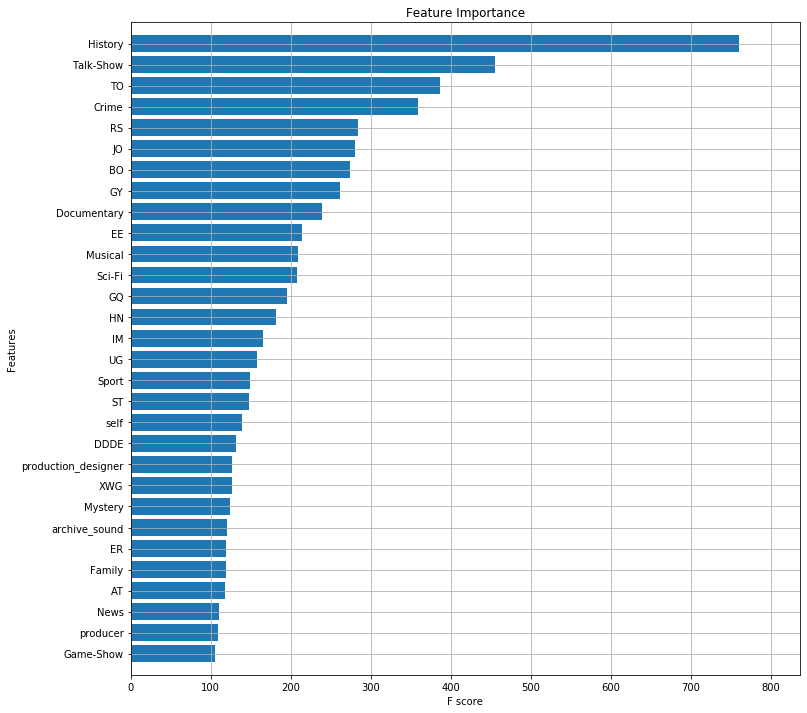

In [117]:
map_names = dict(zip(model.feature_names, columns))
model.feature_names = list(map_names.values())

#plot feature importance
fig, ax = plt.subplots(figsize=(12,12))
xgboost.plot_importance(model, importance_type='gain', max_num_features=30, height=0.8, ax=ax, show_values = False)
plt.title('Feature Importance')
plt.show()

# Deployment

In [16]:
## TO DO

In [120]:
hyper = tuner_log.best_estimator().hyperparameters()

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-11-19 13:25:10 Starting - Preparing the instances for training
2020-11-19 13:25:10 Downloading - Downloading input data
2020-11-19 13:25:10 Training - Training image download completed. Training in progress.
2020-11-19 13:25:10 Uploading - Uploading generated training model
2020-11-19 13:25:10 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[13:14

In [132]:
xgb_model = Estimator.attach('sagemaker-xgboost-201119-1310-001-7d7dab33')

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


2020-11-19 13:25:10 Starting - Preparing the instances for training
2020-11-19 13:25:10 Downloading - Downloading input data
2020-11-19 13:25:10 Training - Training image download completed. Training in progress.
2020-11-19 13:25:10 Uploading - Uploading generated training model
2020-11-19 13:25:10 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:squarederror to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[13:14

In [134]:
# Deploy your model to an endpoint to perform predictions
xgb_predictor = xgb_model.deploy(
    initial_instance_count = 1, 
    instance_type = 'ml.t2.medium',
    endpoint_name = 'niy-xgboost')  

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.
Using already existing model: sagemaker-xgboost-201119-1310-001-7d7dab33


-------------------!

In [21]:
'''
# Configure the predictor's serializer and deserializer

from sagemaker.predictor import csv_serializer, csv_deserializer
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
xgb_predictor.deserializer = csv_deserializer
'''
print()

## Prediction

In [17]:
## TO DO

In [22]:
# xgb_predictor.predict(df_test.values)